# Identifying different vegetation types in UAV data & Sentinel 2 by using Linear Spectral Unmixing

This project aims to identify different vegetation types using the concept of Linear Spectral Unmixing. We use a UAV orthoimage of a study area in the Peruvian Amazon forest. The image was clipped for testing purposes and contains only a part of the existing biodiversity. 

The entire project is based on the assumption that, for example, Sentinel-2 imagery with a spatial resolution of 10 m cannot capture all biodiversity because we will always have the problem of mixed pixels, i.e., each pixel is not "pure" but consists of different "pure" materials. 

Therefore, an attempt was made here to identify different vegetation types in the UAV data that we assume to be "pure" material. This information is then applied to the Sentinel-2 image to determine how much of these different vegetation types can be found in a sentinel pixel.  

In [1]:
from unmixing.utils import as_array
from unmixing.utils import pixel_to_xy
from unmixing.lsma import ravel_and_filter
from unmixing.transform import mnf_rotation
from unmixing.utils import array_to_raster, dump_raster
from unmixing.visualize import FeatureSpace
from unmixing.transform import mnf_rotation
from unmixing.lsma import convex_hull_graham
from unmixing.utils import spectra_at_xy
from unmixing.lsma import FCLSAbundanceMapper
from unmixing.lsma import endmembers_by_maximum_volume

import json

import pysptools.eea as sp_extract

import numpy as np
import pysptools.util as sp_utils

from matplotlib import pyplot as plt, cm
%matplotlib inline

from osgeo import gdal

## Image preprocessing

In the first steps, we explore the data and get rid of all other surface types that are not vegetation and perform a noise and dimensionality reduction.

In [2]:
# load UAV image as 3D NumPy array
image, gt, wkt = as_array('C:/Users/Henrike/Downloads/unmixing-master/unmixing-master/data/test.tif')

GT returns the corner coordinates, pixel size, etc. of the raster

In [3]:
gt

(684544.7354229867,
 0.07000869820171894,
 0.0,
 9572983.114587901,
 0.0,
 -0.07000870104953134)

WKT is the Well-Known Text string describing the projection of the raster.

In [4]:
wkt

'PROJCS["WGS 84 / UTM zone 18S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32718"]]'

In [4]:
# Check the no data value of the image
# file = 'C:/Users/Henrike/Downloads/unmixing-master/unmixing-master/data/test.tif'
# test0 = gdal.Open(file)
# band = test0.GetRasterBand(1)
# band.GetNoDataValue()

0.0

In [3]:
# Create new array that contains boolean of locations where image has no data values
img_na = np.any(image == 0.0, axis = 0)

In [4]:
# copy image to new array and set all zeros to 9999
arrImg = np.copy(image)
arrImg[:, img_na == True] = 9999

Here we use 9999 becasue otherwise the normalization would throw an error.

In [19]:
# Convert array to gdal.Dataset (raster), dump to file
#dump_raster(array_to_raster(arrImg, gt, wkt), 'C:/Users/Henrike/SoftwareDev_Final/test_NoData_v3.tiff', nodata = np.NaN)

In [5]:
# create function to normalize image values between 0 and 1
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [6]:
# apply function to image
scaled_image = NormalizeData(arrImg)
scaled_image.shape

(5, 3689, 6414)

In order to remove all other surface types that are not vegetation, we calculate the NDVI and set a threshold based on visual inspection in QGIS.

In [7]:
# Calculate NDVI
red = scaled_image[2]
nir = scaled_image[4]

ndvi = np.divide((nir - red), (nir + red))

In [16]:
#dump_raster(array_to_raster(ndvi, gt, wkt), 'C:/Users/Henrike/SoftwareDev_Final/NDVI.tiff', nodata = np.NaN)

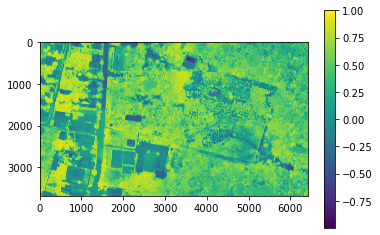

In [8]:
# plot NDVI
plt.imshow(np.squeeze(ndvi))   
plt.colorbar()

In [9]:
# Create classes and apply to NDVI results
ndvi_mask = np.where(ndvi > 0.4, ndvi, -9999) 
ndvi_mask.shape

(3689, 6414)

In [10]:
# Apply mask to scaled image
scaledImg_masked = np.copy(scaled_image)
scaledImg_masked[:, ndvi_mask == -9999] = -9999
scaledImg_masked.shape

(5, 3689, 6414)

In [32]:
#dump_raster(array_to_raster(scaledImg_masked, gt, wkt), 'C:/Users/Henrike/SoftwareDev_Final/test_NDVI_masked.tiff', nodata = np.NaN)

## Dimensionality Reduction

To reduce the noise and dimensionality of the UAV image, a minimum noise fraction (MNF) transformation is applied to the raster.

For further information, refer to https://github.com/arthur-e/unmixing/blob/master/docs/Overview_LSMA_in_Python.ipynb

In [11]:
hsi_post_mnf = mnf_rotation(scaledImg_masked)

In [20]:
#hsi_post_mnf.shape

(6414, 3689, 5)

In [24]:
#hsi_post_mnf.T.shape

(5, 3689, 6414)

In [68]:
#dump_raster(array_to_raster(hsi_post_mnf.T, gt, wkt), 'C:/Users/Henrike/Downloads/unmixing-master/unmixing-master/output/test_MNFRotation.tiff', nodata = -9999)


The plot shows that the first component explains almost all the variance. This can also be seen in the following plot.

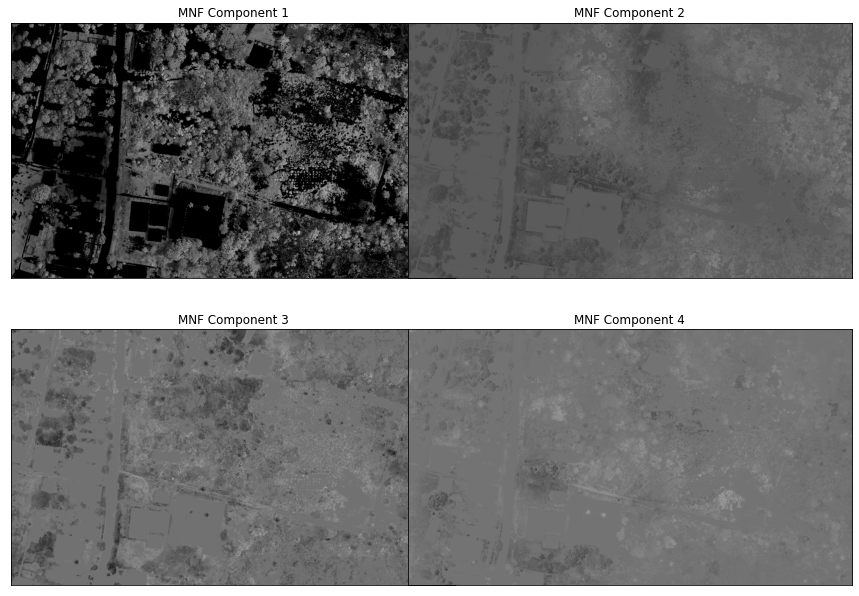

In [12]:
fig = plt.figure(figsize = (16, 16))
fig.subplots_adjust(wspace = -0.2)
for i in range(1, 5):
    ax = fig.add_subplot(320 + i, title = 'MNF Component %d' % i)
    ax.imshow(hsi_post_mnf.T[i - 1,:,:], cmap = cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Endmember extraction

Spectral unmixing is based on the assumption that each pixel can be represented as a (linear) combination of the "pure" material in an image, i.e. each pixel is a mixture of different "pure" signals. Usually, the endmembers are collected in the field, e.g., with an ASD field spectroradiometer, to determine the spectral reflectance of the pure material. 
However, this is costly and time-consuming, so attempts are made to obtain endmembers from the image itself. 
Due to the fact that the study area has a fairly diverse range of species, we attempt to identify endmembers from the UAV data because the resolution is much better.

The Pixel Purity Index (PPI), for example, creates several random projections of the given feature space and then counts how many times each pixel appears in the corners (so in the extremes) across the respective projections.


Instead of using the PPI, here we the Fast Iterative Puritz Index (FIPPI) is used. It has several advantages over the PPI, e.g. instead of using randomly generated vectors as initial endmembers, the FIPPI produces an intial set of endmembers to speed up the process and iteratively tries to find the optimal set of potential endmembers. 

Further information can be found here: [Chang, C.-I. (2006)](https://ieeexplore.ieee.org/document/1576691). 

In [13]:
fippi = sp_extract.FIPPI()

# find 3 potential endmembers and set maximum iteration to 5000
iter_members = fippi.extract(hsi_post_mnf[...,0:3], 3, maxit = 5000)

In [14]:
fippi.get_idx()

# Switch pixel coordinates from (p, m, n) to (n, m, p)
coords = [(y, x) for x, y in fippi.get_idx()]

pixel_to_xy(coords, gt = gt, wkt = wkt, dd = True)

[(-3.861669012382913, -73.33802684504938),
 (-3.862376720033442, -73.33701193223709),
 (-3.863029163231802, -73.33654801527393),
 (-3.8627835156699404, -73.33654471191169),
 (-3.8630348016130243, -73.33651774948143),
 (-3.863964042293433, -73.33515699294598),
 (-3.8621155427946365, -73.3349053222192)]

In [15]:
# Convert array to gdal.Dataset (raster), dump to file
dump_raster(array_to_raster(scaled_image, gt, wkt), 'C:/Users/Henrike/Downloads/unmixing-master/unmixing-master/output/test_arrayImage.tiff', nodata = -9999)

# Set feature_limit = 10000 to minimize computational time
vis_fs = FeatureSpace(path = 'C:/Users/Henrike/Downloads/unmixing-master/unmixing-master/output/test_arrayImage.tiff', nodata = -9999,
                      feature_limit = 10000)

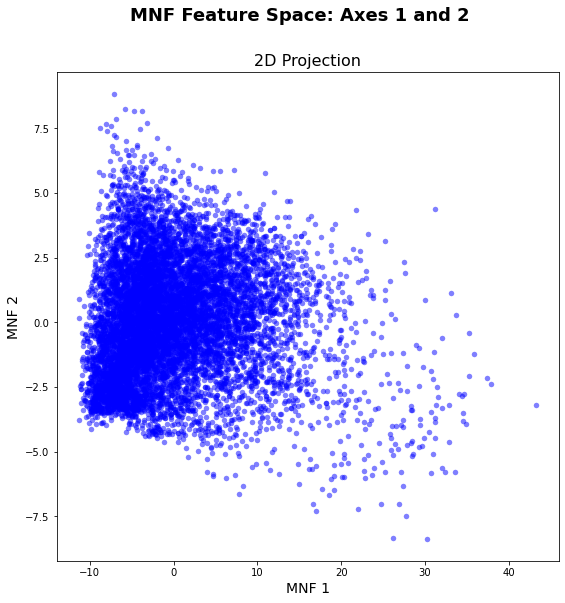

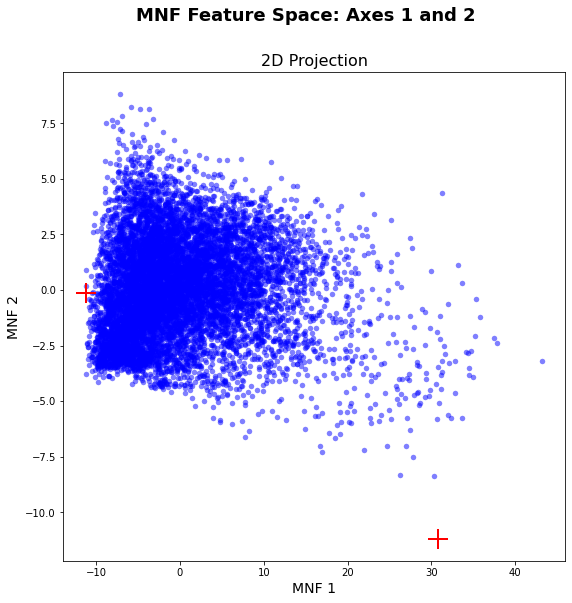

In [16]:
%matplotlib inline
%config InlineBackend.close_figures=False
vis_fs.plot_feature_space()

# Get MNF spectra from the HSI cube using the lat-lon coordinates
lat_lon_coords = pixel_to_xy(coords, gt = gt, wkt = wkt, dd = True)
mnf_spectra = spectra_at_xy(hsi_post_mnf.T, lat_lon_coords, gt, wkt, dd = True)
vis_fs.plot_spectral_points(mnf_spectra)
plt.show()

## Endmember selection with Graham's Scan

As you can see in the graphic above, the automatic endmember selection did not work perfectly. The only endmember that was selected well is the very dark pixel on the far left of the graph. 
This is not surprising, since we are only looking at vegetation surfaces, which is very similar in spectral behavior.

Nevertheless, we want to try to further improve the selection of endmembers. To this end, a set of potential endmembers was collected in SNAP for very bright surfaces, with high values in MNF 1 and medium values in MNF 2 and bright surfaces with high MNF 2 and medium MNF 1 values. The endmember selection is then improved with the Graham scan, using a convex hull to find the potential endmembers. 

In [17]:
# load potential endmembers that were selected in QGIS
with open('C:/Users/Henrike/Downloads/unmixing-master/unmixing-master/data/endmember.json', 'r') as stream:
    veg_pifs = json.load(stream)
    

targets = veg_pifs.copy()
targets

{'bright': [[739389.7354236172, 9556818.114587903],
  [738109.7354235996, 9556458.114587903],
  [733769.7354235434, 9567428.114587903],
  [737679.7354235938, 9563838.114587903]],
 'bright 2': [[710449.735423306, 9552198.114587903],
  [710389.7354233069, 9552828.114587903],
  [708609.7354232938, 9552748.114587903],
  [706769.7354232778, 9552008.114587903]],
 'dark 2': [[711579.7354233158, 9561168.114587903],
  [711459.7354233144, 9561318.114587903],
  [704989.7354232654, 9563388.114587903],
  [705849.7354232725, 9565268.114587903]]}

In [18]:
# Flatten the dictionary to a list
endmember_coords = []
for target in targets.keys():
    endmember_coords.extend(targets[target])
    
# A known shade endmember derived from SNAP
shade_em = (689549.735423172009178, 9538868.114587903022766)
endmember_coords.append(shade_em)

In [19]:
# Get the MNF spectra for each potential endmember
endmember_spectra = spectra_at_xy(hsi_post_mnf.T, endmember_coords, gt, wkt, dd = False)

IndexError: index 783402 is out of bounds for axis 0 with size 6414

In [ ]:
# Find endmembers using Graham's scan
idx, hull = convex_hull_graham(endmember_spectra[...,0:2].tolist(), indices = True)

In [39]:
# Get the coordinate pairs that appeared in the convex hull
hull_coords = [endmember_coords[i] for i in idx]

# A follow-up search by maximum volume
ems, em_coords = endmembers_by_maximum_volume(hsi_post_mnf.T, hull_coords, 
                                              shade_em, gt = gt, wkt = wkt)

NameError: name 'idx' is not defined

In [38]:
hull

[[-9.388941993857719, -0.2609990552859446],
 [16.033588612550286, -5.978408616698709],
 [19.24446189207542, -6.159297741602809],
 [37.61362636062518, -6.351515068322243],
 [35.70588707106526, 0.09461066272233451],
 [31.33043818607463, 7.24761698223953]]

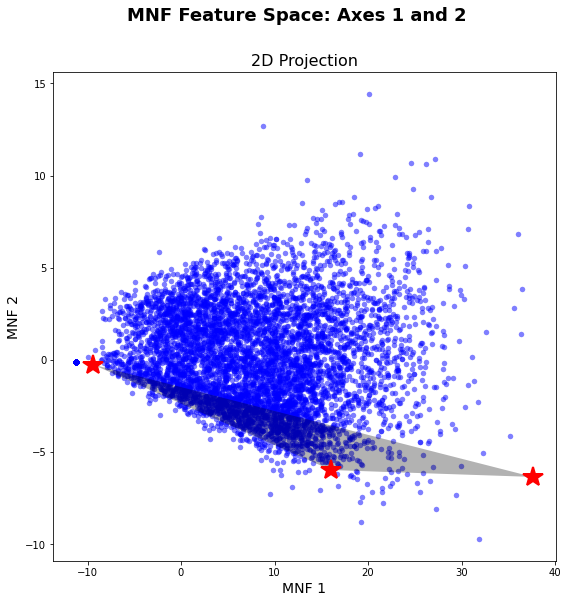

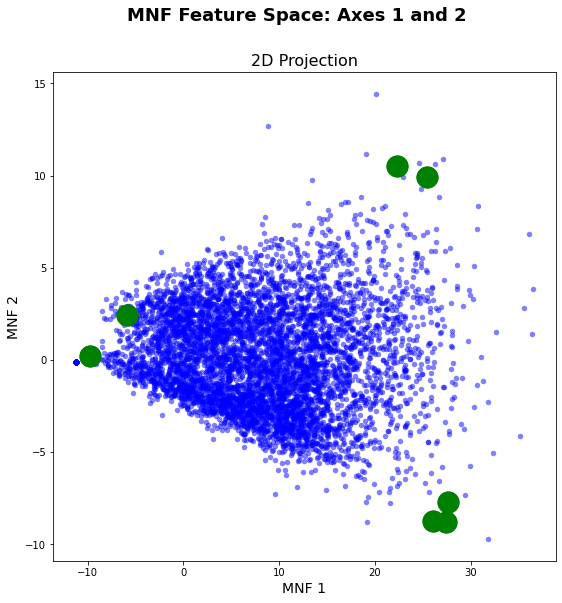

In [77]:
vis_fs.plot_spectral_points(hull, fmt = 'go')
plt.show()

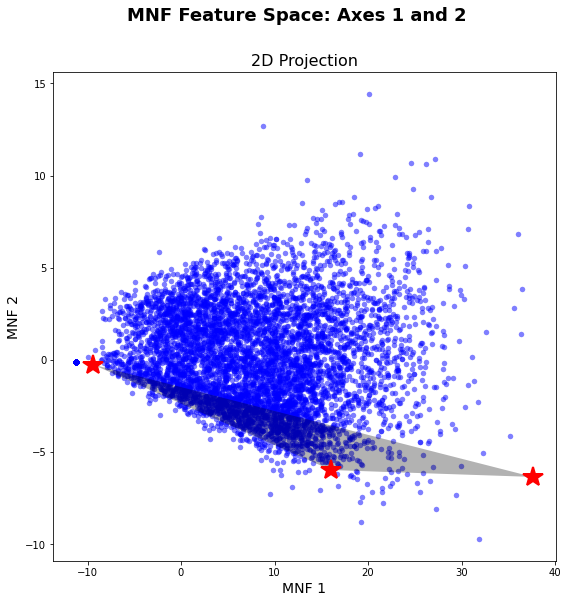

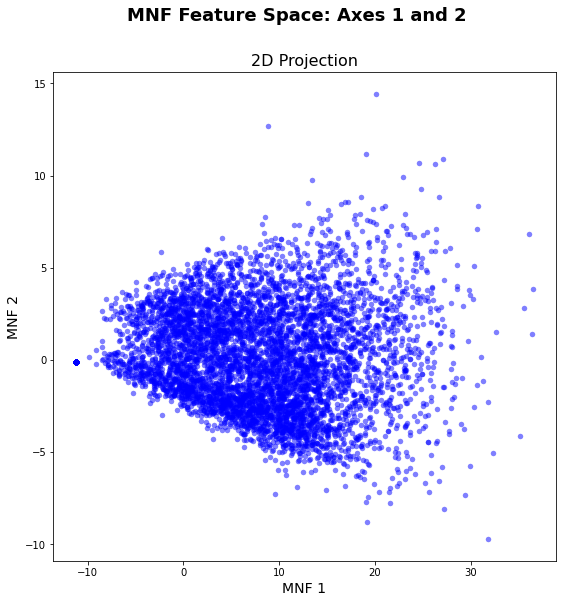

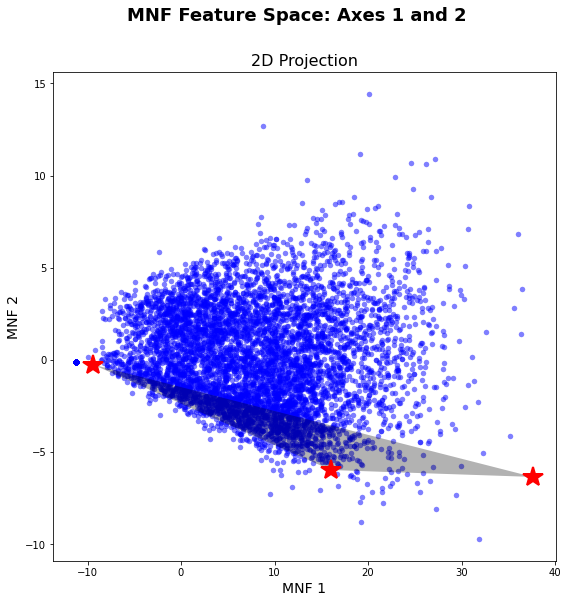

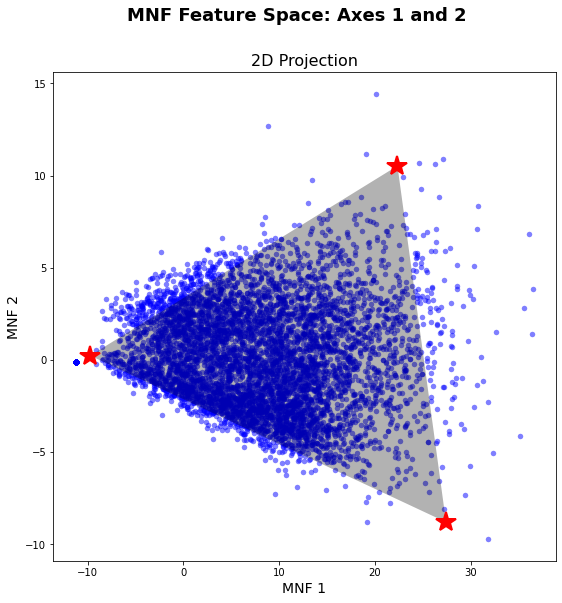

In [78]:
# Get the coordinate pairs that appeared in the convex hull
hull_coords = [endmember_coords[i] for i in idx]

# A follow-up search by maximum volume
ems, em_coords = endmembers_by_maximum_volume(hsi_post_mnf.T, hull_coords, 
                                              shade_em, gt = gt, wkt = wkt)

plt.close()
vis_fs.plot_feature_space()

vis_fs.plot_spectral_points(ems, fmt='r*')
vis_fs.plot_2d_mixing_space(ems)

## Now apply the LSMA to the Sentinel-2 image

A Sentinel-2 Level 2A image for the 03.08.2020 was acquired from the Open Access Hub with a cloud coverage less than 5%. The image was then preprocessed in SNAP. Preprocessing included cloud masking with the Sen2Cor algorithm, subsetting the bands to RGB, NIR, Red Edge 1-3, and SWIR 1 & 2 bands, and resampling of all bands to 10 m. 

In [79]:
# laod image
s2, gt, wkt = as_array('C:/Users/Henrike/Downloads/unmixing-master/unmixing-master/data/S2_20200803.tiff')
s2.shape

(7, 26, 45)

In [80]:
# reduce noise and dimensionality
mnf = mnf_rotation(s2)
fcls_mapper = FCLSAbundanceMapper(mnf.T, gt, wkt, processes = 6)

In [81]:
# apply fully contraint LSMA
result = fcls_mapper.map_abundance(ems)

In [83]:
result.shape

(45, 26, 3)

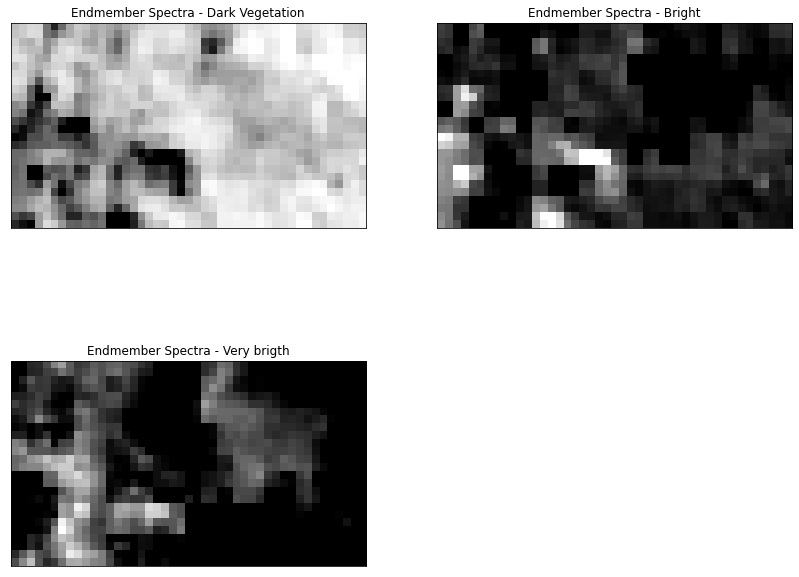

In [82]:
fig = plt.figure(figsize = (14, 14))
fig.subplots_adjust(hspace = -0.2)
endmember_labels = ['Dark Vegetation', 'Bright', 'Very brigth']
for i in range(0, 3):
    ax = fig.add_subplot(221 + i, title = 'Endmember Spectra - %s' % endmember_labels[i])
    ax.imshow(result.T[i,...], cmap = cm.gray)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [67]:
dump_raster(array_to_raster(result.T, gt, wkt), 'C:/Users/Henrike/Downloads/unmixing-master/unmixing-master/output/test_S2_result.tiff', nodata = -9999)
